## Getting Started with pyDelta's _next_ branch

pyDelta's _next_ branch contains our work-in-progress implementation of experiments using Delta variants as a python library. We assume you have installed the library using `pip`.

First, let's import the delta package:

In [1]:
import delta

### Loading the corpus and preparing the feature matrix

The [Corpus](delta.html#delta.corpus.Corpus) class represents the corpus as a bag-of-words feature matrix. In its simplest form, you can just call `Corpus` and pass it the directory your texts reside in:

In [2]:
raw_corpus = delta.Corpus('../../refcor/English')

This simple form assumes your texts in plain text files following the pattern `Author_Title.txt`. The reference corpora of English, French and German novels we use [can be found on Github](https://github.com/cophi-wue/refcor). If your corpus looks different, or if you need other ways of feature extraction than our simple tokenizer regular expression, have a look at the full documentation of our Corpus class for ways of parametrizing or further customizing feature extraction.

`Corpus` is simply a subclass of pandas' DataFrame. The rows represent the documents, the columns the individual types. Let's look at the Corpus' top left corner:

In [3]:
print(raw_corpus.shape)
raw_corpus.iloc[0:5,0:10]

(75, 87829)


,the,and,to,of,a,I,in,was,that,he
ward_ashe,6904.0,4523.0,3498.0,4071.0,3185.0,1859.0,2278.0,1928.0,1528.0,1466.0
blackmore_springhaven,9965.0,6555.0,5865.0,6539.0,4637.0,2896.0,2449.0,2156.0,2572.0,2244.0
stevenson_island,4075.0,2680.0,1508.0,1671.0,1720.0,1965.0,932.0,1130.0,857.0,808.0
thackeray_esmond,9742.0,7992.0,4907.0,5541.0,4158.0,1898.0,2981.0,2755.0,2432.0,2385.0
ward_milly,2098.0,2189.0,1262.0,716.0,1058.0,596.0,565.0,563.0,364.0,298.0


The matrix contains the absolute frequencies of each word in each document, columns are sorted by the sum of all absolute frequencies.

Corpus has a few methods to manipulate the feature matrix, e.g., to perform culling: To remove all tokens that are not present in at least ⅓ of all documents, use

In [4]:
culled_corpus = raw_corpus.cull(1/3)
print(culled_corpus.shape)

(75, 10039)


Unless documented otherwise, these method return a new modified corpus instead of changing the current one.


For most experiments, you'll want to work on [the relative frequencies](delta.html#corpus.Corpus.relative_frequencies) of [the $n$ most frequent words](delta.html#corpus.Corpus.topn). There is a  [combined method](delta.html#corpus.Corpus.get_mfw_table) for that:

In [5]:
c2500 = raw_corpus.get_mfw_table(2500)

### Using delta functions to create a distance matrix

pydelta provides a number of delta functions by name that all produce a [distance matrix](delta.html#deltas.DistanceMatrix). To run, e.g., Cosine Delta on our corpus from above:

In [6]:
distances = delta.functions.cosine_delta(c2500)
distances.iloc[:5,:5]

,ward_ashe,blackmore_springhaven,stevenson_island,thackeray_esmond,ward_milly
ward_ashe,0.000000,1.172292,1.102327,1.036012,1.014371
blackmore_springhaven,1.172292,0.000000,0.901935,0.949230,0.999159
stevenson_island,1.102327,0.901935,0.000000,1.059726,0.874804
thackeray_esmond,1.036012,0.949230,1.059726,0.000000,1.082447
ward_milly,1.014371,0.999159,0.874804,1.082447,0.000000


It is possible to run a few evaluations already on the distance matrix:

In [7]:
distances.evaluate()

F-Ratio         0.405758
Fisher's LD     1.328287
Simple Score    3.613850
dtype: float64

F-Ratio and Fisher's Linear Discriminant are established measures (see Heeringa et al., 2008), to calculate the _Simple Score_ we first standardize the distances and then calculate the difference between the mean distances between out-group and in-group texts (i.e., texts by different authors and texts by the same author).

You can also get the distances as a flat table. This will effectively return a flattened version of the lower right triangle of the distance matrix above, as `scipy.spatial.distance.squareform(distances)` would do, but with a proper index:

In [8]:
distances.delta_values()

ward_ashe          blackmore_springhaven    1.172292
                   stevenson_island         1.102327
                   thackeray_esmond         1.036012
                   ward_milly               1.014371
                   burnett_lord             0.953704
                                              ...   
james_muse         lytton_novel             0.989467
                   doyle_lost               1.054597
james_ambassadors  lytton_novel             1.017272
                   doyle_lost               0.982058
lytton_novel       doyle_lost               1.064256
Length: 2775, dtype: float64

### Clustering results

It is common to use _clustering_ on the basis of the distance matrix in order to group similar texts. pydeltas [Clustering](delta.rst#cluster.Clustering) class is a convenience wrapper around hierarchical clustering methods, of which _Ward clustering_ is the default:

In [9]:
clustering = delta.Clustering(distances)

A hierarchical clustering is typically visualized using a _Dendrogram_. We've [included an implementation](delta.html#graph.Dendrogram) that colors by author and provides labels using the [DocumentDescriber](delta.html#corpus.DocumentDescriber) that is assigned when creating the corpus:

/home/tv/git/pydelta/delta/graphics.py:89: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(2)


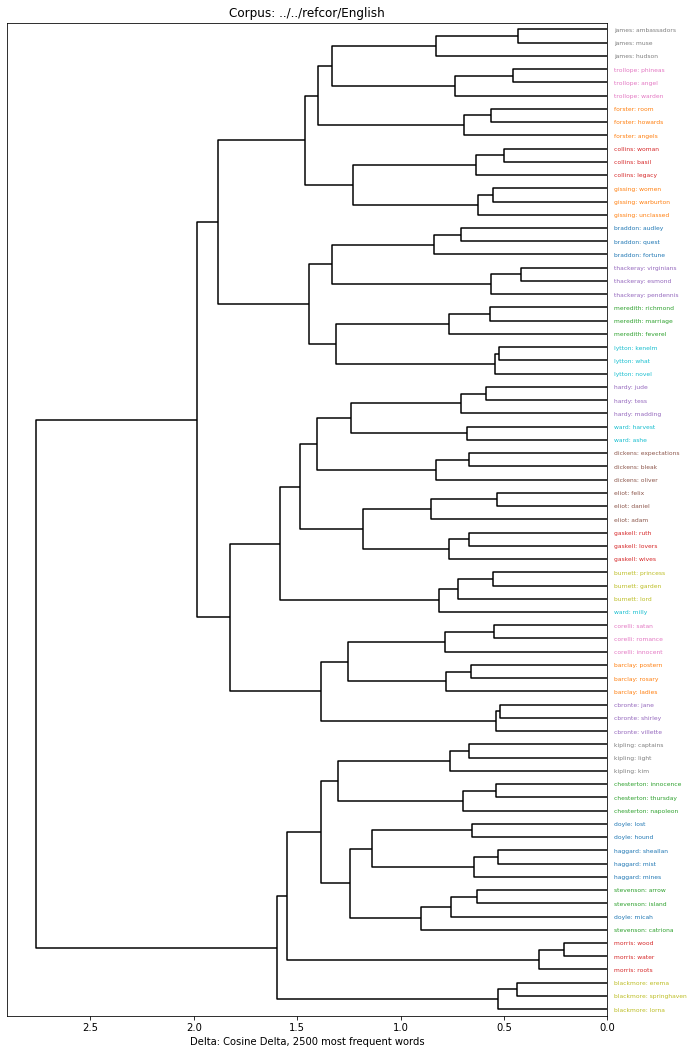

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,15))
delta.Dendrogram(clustering).show()

For any but a visual inspection, it is probably best to cut through the hierarchical clustering to provide flat clusters. This can be done with default settings from the hierarchical clustering:

In [11]:
clusters = clustering.fclustering()
print(clusters.describe())

25 clusters of 75 documents (ground truth: 25 groups):
{1: ['blackmore: springhaven', 'blackmore: erema', 'blackmore: lorna'],
 2: ['morris: water', 'morris: roots', 'morris: wood'],
 3: ['stevenson: island', 'stevenson: arrow', 'doyle: micah',
     'stevenson: catriona'],
 4: ['haggard: mist', 'haggard: sheallan', 'haggard: mines'],
 5: ['doyle: hound', 'doyle: lost'],
 6: ['chesterton: napoleon', 'chesterton: thursday', 'chesterton: innocence'],
 7: ['kipling: kim', 'kipling: light', 'kipling: captains'],
 8: ['cbronte: shirley', 'cbronte: villette', 'cbronte: jane'],
 9: ['barclay: ladies', 'barclay: rosary', 'barclay: postern'],
 10: ['corelli: innocent', 'corelli: romance', 'corelli: satan'],
 11: ['ward: milly', 'burnett: lord', 'burnett: garden', 'burnett: princess'],
 12: ['gaskell: lovers', 'gaskell: ruth', 'gaskell: wives'],
 13: ['eliot: adam', 'eliot: daniel', 'eliot: felix'],
 14: ['dickens: bleak', 'dickens: oliver', 'dickens: expectations'],
 15: ['ward: ashe', 'ward: ha

There are also some measures of cluster quality built into [our class](delta.rst#cluster.FlatClustering):

In [12]:
clusters.evaluate()

Cluster Errors         2.000000
Adjusted Rand Index    0.932358
Homogeneity            0.981365
Completeness           0.984136
V Measure              0.982749
Purity                 0.973333
Entropy                0.018635
dtype: float64